In [1]:
import sys

sys.path.append('..')

import os
import os.path as osp
import joblib
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from envs import CFR_A
from argparse import Namespace
import matplotlib as mpl

cmap = sns.cubehelix_palette(as_cmap=True)
%config InlineBackend.figure_format = 'retina'

In [2]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['pdf.fonttype'] = 3
mpl.rcParams['ps.fonttype'] = 3
mpl.rcParams['font.family'] = 'Times New Roman'
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [3]:
def load_policy_and_env(fpath, itr="last", deterministic=False):
    if itr == "last":
        pytsave_path = osp.join(fpath, "pyt_save")
        saves = [
            int(x.split(".")[0][5:])
            for x in os.listdir(pytsave_path)
            if len(x) > 8 and "model" in x
        ]
        itr = "%d" % max(saves) if len(saves) > 0 else ""
    else:
        assert isinstance(
            itr, int
        ), "Bad value provided for itr (needs to be int or 'last')."
        itr = "%d" % itr
    get_ftns = load_pytorch_policy(fpath, itr, deterministic)

    try:
        state = joblib.load(osp.join(fpath, "vars" + itr + ".pkl"))
        env = state["env"]
    except:
        env = None

    return env, get_ftns


def load_pytorch_policy(fpath, itr, 
                        deterministic=False, device="cpu"):
    """ Load a pytorch policy saved with Spinning Up Logger."""

    fname = osp.join(fpath, "pyt_save", "model" + itr + ".pt")
    model = torch.load(fname, map_location=torch.device(device))
    get_ftns = {}
                                     
    # make function for producing an action given a single state
    def get_action(x):
        if deterministic:
            with torch.no_grad():
                x = torch.as_tensor(x, dtype=torch.float32, device=device)
                logit = model.pi.logits_net(x)
                _, indices = torch.max(logit, 1)
                action = indices.float().cpu().numpy()
            return action
        else:
            with torch.no_grad():
                x = torch.as_tensor(x, dtype=torch.float32, device=device)
                action = model.act(x)
            return action

    def get_p(x):
        with torch.no_grad():
            x = torch.as_tensor(x, dtype=torch.float32, device=device)
            logit = model.pi.logits_net(x)
        return F.softmax(logit, dim=-1).cpu().numpy()
    
    def get_v(x):
        with torch.no_grad():
            x = torch.as_tensor(x, dtype=torch.float32, device=device)
            v = model.v(x)
        return v.cpu().numpy()
    
    get_ftns = {'a' : get_action, 'pi': get_p, 'v': get_v}
    return get_ftns    

## $N=1$: MLP policy

In [4]:
opt = Namespace()
opt.fpath = 'runs/ppo_CFR-A_Arch-mlp_N1/ppo_CFR-A_Arch-mlp_N1_s0/'
opt.deterministic = True
env, get_ftns = load_policy_and_env(
    opt.fpath, 'last', opt.deterministic)

/Users/kdkyum/.anaconda3/envs/ratchet/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/kdkyum/.anaconda3/envs/ratchet/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/kdkyum/.anaconda3/envs/ratchet/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can r

<Figure size 400x400 with 0 Axes>

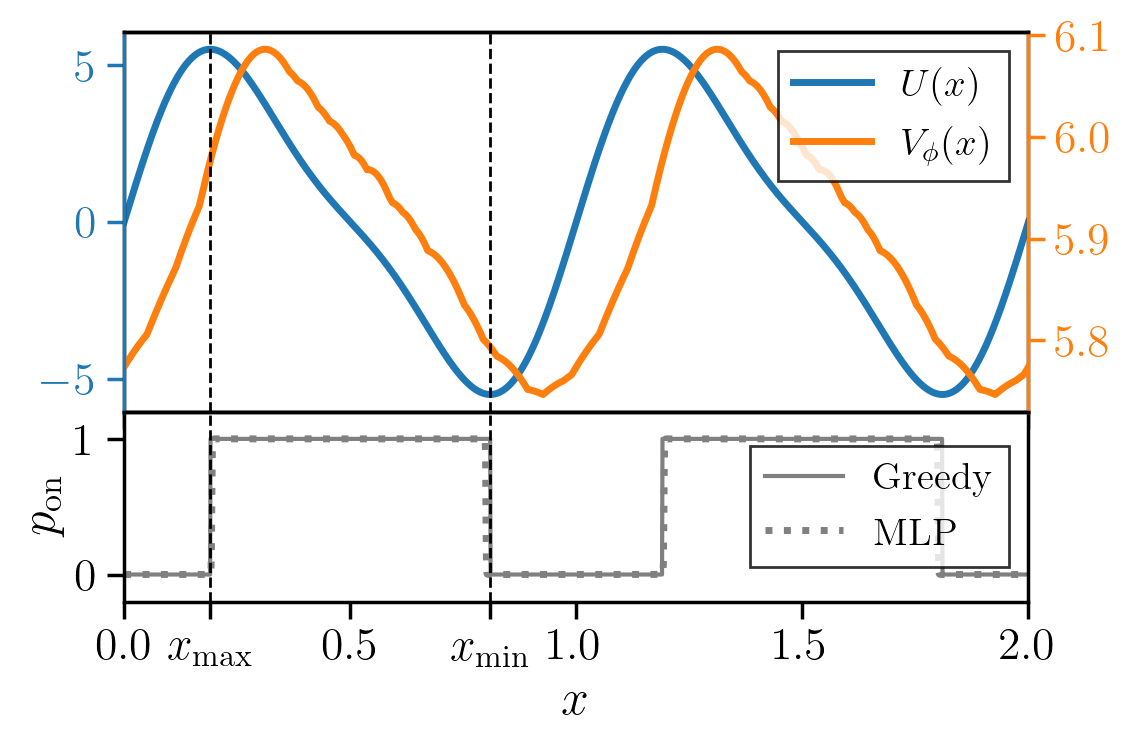

In [5]:
# Three subplots sharing both x/y axes
plt.figure(figsize=(4,4))
x_max = (np.arctan(np.sqrt(-3 + 2 * np.sqrt(3))) / np.pi)
x_min = -0.19035916268766679

f, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1.5]}, figsize=(6,4))
get_p = get_ftns['pi']
get_v = get_ftns['v']
x = np.linspace(0, 2, 2000)
u = env.potential(x)
s = np.stack([np.cos(2 * np.pi * x / env.a), 
              np.sin(2 * np.pi * x / env.a)], axis=-1).reshape(-1, 1, 2)
v = get_v(s).squeeze()

ax1.plot(x, u, label=r'$U(x)$')
ax1.set_xlim(0, 2)
ax1.tick_params(axis='y', color='C0', labelcolor='C0')

twin_ax1 = ax1.twinx()
twin_ax1.plot([], [], c='C0', label=r'$U(x)$')
twin_ax1.plot(x, v, c='C1', label=r'$V_{\phi}(x)$')
twin_ax1.tick_params(axis='y', color='C1', labelcolor='C1')
twin_ax1.legend(loc=1, fontsize=14)
twin_ax1.spines['right'].set_color('C1')
twin_ax1.spines['left'].set_color('C0')
twin_ax1.axvline(x_max, lw=1, ls='--', c='black')
twin_ax1.axvline(x_min+1, lw=1, ls='--', c='black')

get_action = env.get_greedy_action()
a = get_action(s)
p = get_p(s)[:, 1]

ax2.plot(x, a.squeeze(), c='grey', lw=1.5, label='Greedy')
ax2.plot(x, p.squeeze(), ':', c='grey', lw=2.5, label='MLP')
ax2.set_ylabel(r'$p_{\rm on}$')
ax2.set_ylim(-0.2, 1.2)
ax2.set_xlabel(r'$x$')
ax2.axvline(x_max, lw=1, ls='--', c='black')
ax2.axvline(x_min+1, lw=1, ls='--', c='black')
ax2.set_xticks([0.0, x_max, 0.5, 1+x_min, 1.0, 1.5, 2.0])
ax2.set_xticklabels([0.0, r'$x_{\rm max}$', 0.5, r'$x_{\rm min}$', 1.0, 1.5, 2.0])

ax2.legend(fontsize=14)
plt.tight_layout()
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=True)
plt.show()

## $N=2$: MLP policy

In [6]:
opt = Namespace()
opt.fpath = 'runs/ppo_CFR-A_Arch-mlp_N2/ppo_CFR-A_Arch-mlp_N2_s4/'
opt.len = 10000
opt.itr = -1
opt.deterministic = True
env, get_ftns= load_policy_and_env(
    opt.fpath, opt.itr if opt.itr >= 0 else 'last', opt.deterministic)

/Users/kdkyum/.anaconda3/envs/ratchet/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/kdkyum/.anaconda3/envs/ratchet/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/kdkyum/.anaconda3/envs/ratchet/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can r

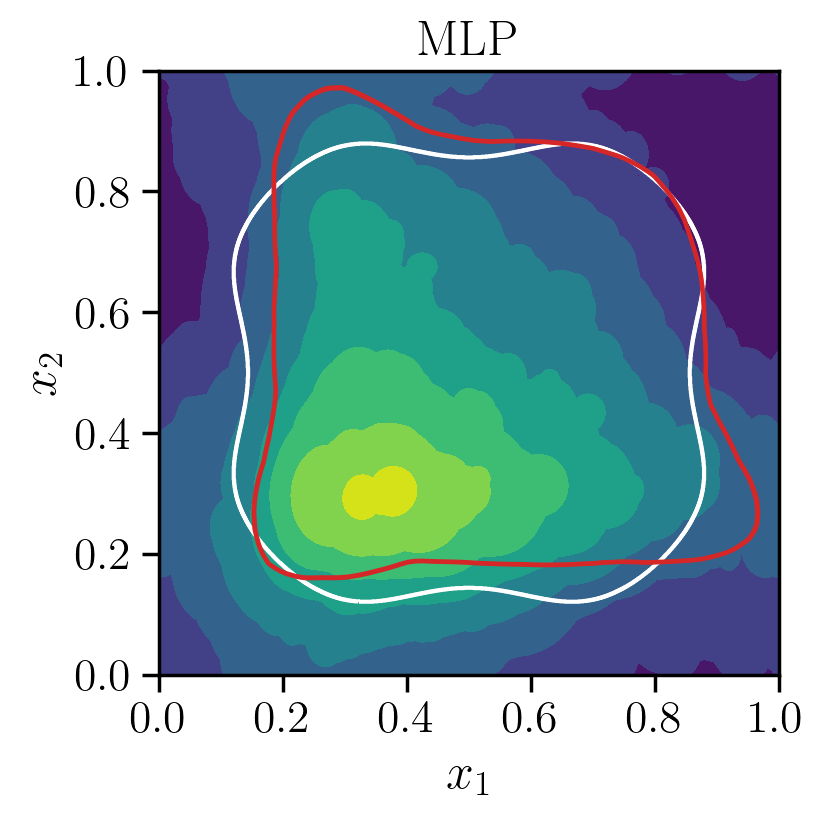

In [7]:
L=800*2
phi1 = np.linspace(0, 2*np.pi, L)
phi2 = np.linspace(0, 2*np.pi, L)
xx, yy = np.meshgrid(phi1, phi2, sparse=False)
get_p = get_ftns['pi']
get_v = get_ftns['v']
phis = np.stack([xx, yy], axis=-1).reshape(-1, 2, 1)
s = np.concatenate([np.cos(phis), np.sin(phis)], axis=-1)
p = get_p(s)[:, 1]
v = get_v(s).squeeze()

f = plt.figure(figsize=(4, 4))
plt.title('MLP')

h = plt.contourf(phi1/(2*np.pi), phi2/(2*np.pi), v.reshape(L, L))#, vmin=4.05, vmax=4.45)

get_action = env.get_greedy_action()
a = get_action(s)

plt.contour(phi1/(2*np.pi), phi2/(2*np.pi), a.reshape(L, L),
            levels = [0.01], colors=('white',),linestyles=('-',),linewidths=(1.5,))
plt.contour(phi1/(2*np.pi), phi2/(2*np.pi), p.reshape(L, L),
               levels = [0.4, 0.6], colors=('C3',),linestyles=('-',),linewidths=(1.5,))

plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

## $N=2$: DeepSets policy

In [8]:
opt = Namespace()
opt.fpath = 'runs/ppo_CFR-A_Arch-ds_N2/ppo_CFR-A_Arch-ds_N2_s4/'
opt.len = 10000
opt.itr = -1
opt.deterministic = True
env, get_ftns= load_policy_and_env(
    opt.fpath, opt.itr if opt.itr >= 0 else 'last', opt.deterministic)

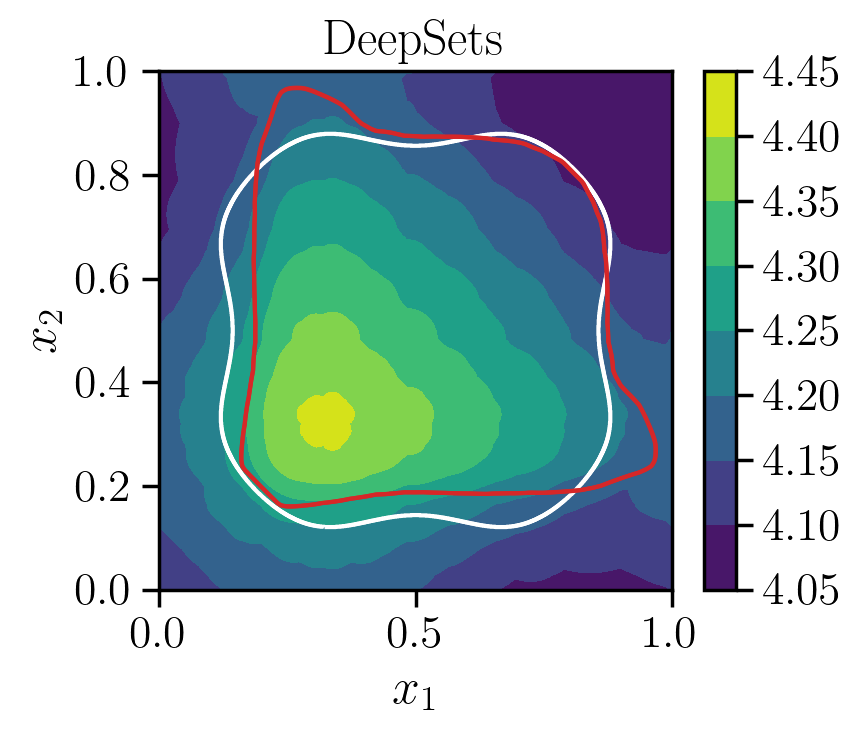

In [9]:
L=800*2
phi1 = np.linspace(0, 2*np.pi, L)
phi2 = np.linspace(0, 2*np.pi, L)
xx, yy = np.meshgrid(phi1, phi2, sparse=False)
get_p = get_ftns['pi']
get_v = get_ftns['v']
phis = np.stack([xx, yy], axis=-1).reshape(-1, 2, 1)
s = np.concatenate([np.cos(phis), np.sin(phis)], axis=-1)
p = get_p(s)[:, 1]
v = get_v(s).squeeze()

f = plt.figure(figsize=(4, 4))
plt.title('DeepSets')
get_action = env.get_greedy_action()
a = get_action(s)
h = plt.contourf(phi1/(2*np.pi), phi2/(2*np.pi), v.reshape(L, L), vmin=4.05, vmax=4.45)
plt.contour(phi1/(2*np.pi), phi2/(2*np.pi), a.reshape(L, L), 
            levels = [0.01], colors=('white',),linestyles=('-',),linewidths=(1.5,))
plt.contour(phi1/(2*np.pi), phi2/(2*np.pi), p.reshape(L, L), levels = [0.45, 0.55],
                colors=('C3',),linestyles=('-',),linewidths=(1.5,))
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
ax = plt.gca()
plt.tight_layout()
cax = f.add_axes([ax.get_position().x1+0.04,ax.get_position().y0, 0.04,ax.get_position().height])
cbar = plt.colorbar(h, cax=cax)
plt.show()